# Take Home Challeng Relax Inc

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import datetime
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [203]:
df_engage=pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])

In [204]:
df_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [205]:
df_engage.shape

(207917, 3)

In [206]:
#count the number of missing values
miss_value = pd.concat([df_engage.isnull().sum(), 100 * df_engage.isnull().mean()], axis=1)
miss_value.columns=['count', '%']
miss_value.sort_values(by=['%'],ascending=False)

,count,%
time_stamp,0,0.0
user_id,0,0.0
visited,0,0.0


Nothing is missing, awesome

In [207]:
print("There are ", + len(pd.unique(df_engage['user_id'])), ' unique users', " out of ", len(df_engage['user_id']))

There are  8823  unique users  out of  207917


In [208]:
df_users = pd.read_csv("takehome_users.csv", encoding='latin-1', parse_dates=True)

In [209]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [210]:
#count the number of missing values
miss_value = pd.concat([df_users.isnull().sum(), 100 * df_users.isnull().mean()], axis=1)
miss_value.columns=['count', '%']
miss_value.sort_values(by=['%'],ascending=False)

,count,%
invited_by_user_id,5583,46.525
last_session_creation_time,3177,26.475
object_id,0,0.000
creation_time,0,0.000
name,0,0.000
email,0,0.000
creation_source,0,0.000
opted_in_to_mailing_list,0,0.000
enabled_for_marketing_drip,0,0.000
org_id,0,0.000


Over 46.5% is missing in the invited by user ide column. last session creation time is missing 26% of its value. 

# Data Cleaning

In [211]:
# Convert datetime columns to datetime format
df_engage['time_stamp'] = pd.to_datetime(df_engage['time_stamp'], format='%Y-%m-%d %H:%M:%S')
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'], format='%Y-%m-%d %H:%M:%S')

In [212]:
df_users = df_users.drop(['org_id'], axis=1) # drop the columns that are missing values

In [213]:
df_users.invited_by_user_id = df_users.invited_by_user_id.fillna(0)

In [214]:
# universal time conversion
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit = 's')

# Create the adopted user table

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period , identify which factors predict future user adoption .

In [215]:

df_engage = df_engage.set_index('time_stamp', drop= True)


In [216]:
days_change = timedelta(days=7)

adopted = 0
def indicator(x):    #define a function to indicate 7 days activities of the user
    df = df_engage.loc[df_engage['user_id'] == x] #select out rows of this user
    df = df.resample('D',on= 'time_stamp') #resample to show if active in a day.
    
    for i in range(len(df)-2): #loop over active days till the second to last day
        if df.index[i + 2] - df.index[i] <= days_change: # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [224]:
def indicator(x):    #define a function to indicate 7 days activities of the user
    df = df_engage.loc[df_engage['user_id'] == x] #select out rows of this user
    df = df.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    count = 0
    for i in range(len(df)-2): #loop over active days till the second to last day
        if df.index[i + 2] - df.index[i] <= days_change: # difference between every 1st and 3rd day
            count = 1
            break
        else:
            count = 0
    return count

In [225]:
df_users['adopted_user'] = df_users['object_id'].apply(indicator)

In [226]:
df_users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,1525.0,0


In [227]:
print('{} of the users were adopted out of {} users'.format(
    sum(df_users['adopted_user']), len(df_users['adopted_user'])))

1656 of the users were adopted out of 12000 users


# Exploratory Analysis

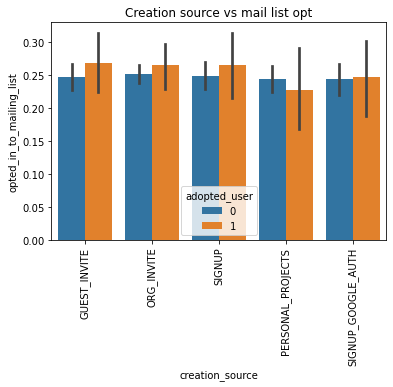

In [228]:
ax = sns.barplot(data=df_users,x = 'creation_source',y= 'opted_in_to_mailing_list', hue = 'adopted_user') #plotting active riders by city and first 30days trip
ax.set_title("Creation source vs mail list opt")
plt.xticks(rotation=90)
plt.show()

Guests invited which have limitied permision were more likely to opt in mail list and more likely to be an adopted user too.

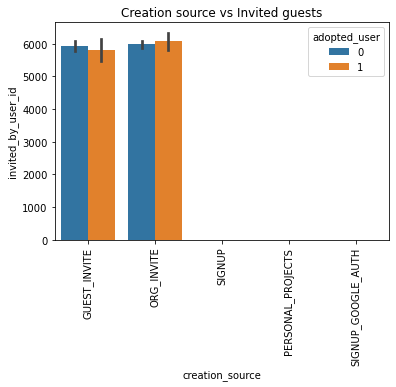

In [229]:
ax = sns.barplot(data=df_users,x = 'creation_source',y= 'invited_by_user_id', hue = 'adopted_user') #plotting active riders by city and first 30days trip
ax.set_title("Creation source vs Invited guests")
plt.xticks(rotation=90)
plt.show()

most of the invitation by user id were via org invite or the usual guest invite

# Trian/Split

In [230]:
names_list = ['name', 'email', 'object_id', 'creation_time', 'last_session_creation_time', 'invited_by_user_id']

In [231]:
df_cat = pd.DataFrame.copy(df_users)

In [233]:
df_cat.drop(columns=names_list, inplace = True, axis=1) # create a categorical dataframe to store the new values

In [234]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   creation_source             12000 non-null  object
 1   opted_in_to_mailing_list    12000 non-null  int64 
 2   enabled_for_marketing_drip  12000 non-null  int64 
 3   adopted_user                12000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 375.1+ KB


In [235]:
df_cat.head(10)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user
0,GUEST_INVITE,1,0,0
1,ORG_INVITE,0,0,1
2,ORG_INVITE,0,0,0
3,GUEST_INVITE,0,0,0
4,GUEST_INVITE,0,0,0
5,GUEST_INVITE,0,0,0
6,SIGNUP,0,1,0
7,PERSONAL_PROJECTS,1,1,0
8,PERSONAL_PROJECTS,0,0,0
9,ORG_INVITE,1,1,1


Note: " creation_source:   how  their  account  was  created.  This  takes  on  one
of  5  values:
○ PERSONAL_PROJECTS:  invited  to  join  another  user's
personal  workspace
○ GUEST_INVITE:  invited  to  an  organization  as  a  guest
(limited  permissions)
○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
○ SIGNUP:  signed  up  via  the  website
○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google
Authentication  (using  a  Google  email  account  for  their  login
id)"

In [237]:
#create a new column to replace the creation source. Guest invite will represent 1 while Signup_google_auth will be 5
dict = {'GUEST_INVITE':1,'ORG_INVITE':2,'SIGNUP':3,'PERSONAL_PROJECTS':4,'SIGNUP_GOOGLE_AUTH':5}
df_cat['creation_source'] = df_cat['creation_source'].map(lambda i: dict[i])

In [238]:
df_cat.head(3)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user
0,1,1,0,0
1,2,0,0,1
2,2,0,0,0


In [239]:
#chose the indepent and dependent variables for the regression analysis
X = df_cat.drop(['adopted_user'], axis =1)

y = df_cat.adopted_user

In [240]:
from sklearn.model_selection import train_test_split
# The test_size--> train with 75% of the data, and test on 25%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state  = 42)

# Random Forest

In [272]:
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [100, 150, 200]}
model = GridSearchCV(clf, params)
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 100}
Best average precision was 0.5418888888888889


In [280]:
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced_subsample', n_estimators=100
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.513
              precision    recall  f1-score   support

           0       0.88      0.50      0.64      2580
           1       0.16      0.58      0.25       420

    accuracy                           0.51      3000
   macro avg       0.52      0.54      0.44      3000
weighted avg       0.78      0.51      0.58      3000



# Set up for classification

In [274]:
import sklearn.model_selection
#create the cv_optimize function to be used for the classification
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain) # fit the the train data
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [275]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

# Basic Logistic Regression

In [276]:
from sklearn.linear_model import LogisticRegression
# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(df_cat[['creation_source','opted_in_to_mailing_list']].values, 
                                              (df_cat.adopted_user == 1).values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.8593333333333333


In [277]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           df_cat, ['creation_source','opted_in_to_mailing_list'], 'adopted_user',1)

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.86
Accuracy on test data:     0.86


86% for predicting adopted user by creation source and opt in mail list

In [279]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           df_cat, ['creation_source','enabled_for_marketing_drip'], 'adopted_user',1)

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.86
Accuracy on test data:     0.87


When enabled_for_marketing_drip was used, the testing set accuracy went up by 1% but the training remained the same. 

# Conclusion

Opt in mail list is one of the leading signs of future adopted user.  The basic logistic regression model performed well over the random forest model with 51% accuracy. My recommendation would be to encourage more org invite as it is clear that it helps increase the chances of having an adopted user. More attention should be given to guest invite, org invite, sign up and signup google auth users as they showed promising path towards becoming an adopted use. Overall, watch out for those users who opt in for mail list they could be your next adopted user soon. 